## 点云处理：实现PointNet点云分割

**作者信息：** [lzzzzzm](https://github.com/lzzzzzm)

**创建日期：** 2022年10月26日

**摘要：** 本示例在于演示如何基于 PaddlePaddle 2.3.2实现PointNet在ShapeNet数据集上进行点云分割。

## 1、简要介绍

点云是一种不同于图片的数据存储结构，其特有的无序性，使其在利用深度网络处理时，需要进行特殊的处理。常见的处理方法有将点云处理成体素后，以某种方式将体素转换为图片后进行处理，但这种方法往往伴随着计算量大等缺点。PointNet系列的模型在模型的设计上，考虑到了点云的无序性特点，使其可以直接对点云数据处理，大大降低了计算量。PointNet系列的模型以简单的结构，同时兼顾了点云分类，零件分割到语义解析任务。

本项目基于PointNet实现对物体零件分割功能

## 2、环境设置

In [20]:
import os
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", module="matplotlib")
from mpl_toolkits.mplot3d import Axes3D

# paddle相关库
import paddle
from paddle.io import Dataset
import paddle.nn.functional as F
from paddle.nn import (
    Conv2D,
    MaxPool2D,
    Linear,
    BatchNorm,
    Dropout,
    ReLU,
    Softmax,
    Sequential,
)

# 查看paddle版本
print("本项目使用paddle版本:{}".format(paddle.__version__))

本项目使用paddle版本:2.3.2


## 3、数据集

ShapeNet 数据集是一项持续的工作，旨在建立一个带有丰富注释的大规模 3D 形状数据集。形状网核心是完整形状网数据集的子集，具有干净的单个3D模型和手动验证的类别和对齐注释。它涵盖了55个常见的对象类别，约有51，300个独特的3D模型。

对于此示例，我们使用 PASCAL 3D+ 的 12 个对象类别之一,以飞机的零件分割为例，该类别作为 ShapenetCore 数据集的一部分包含在内。

完整的数据集下载地址：https://shapenet.cs.stanford.edu/iccv17/

In [ ]:
# 解压数据集，并放到dataset这个文件夹下
!mkdir dataset
!unzip -q data/data174089/shapenet.zip -d dataset/

### 3.1点云数据可视化

点云数据的获取方式，一般都是使用深度相机或者雷达，其存储的形式一般为一个(N，4)的向量，其中N代表着这次采集的点云数量，4代表着其中每个点在三维的坐标x，y，z和反射强度r，但在本次的数据集中，点云的存储方式为（N，3），即不包括点云的反射强度r。

而label的存储方式则是为一个N维的向量，代表每个点具体的类别

下面，我们通过读取点云的数据和其label，对我们需要处理的数据，有一个大致的认识。



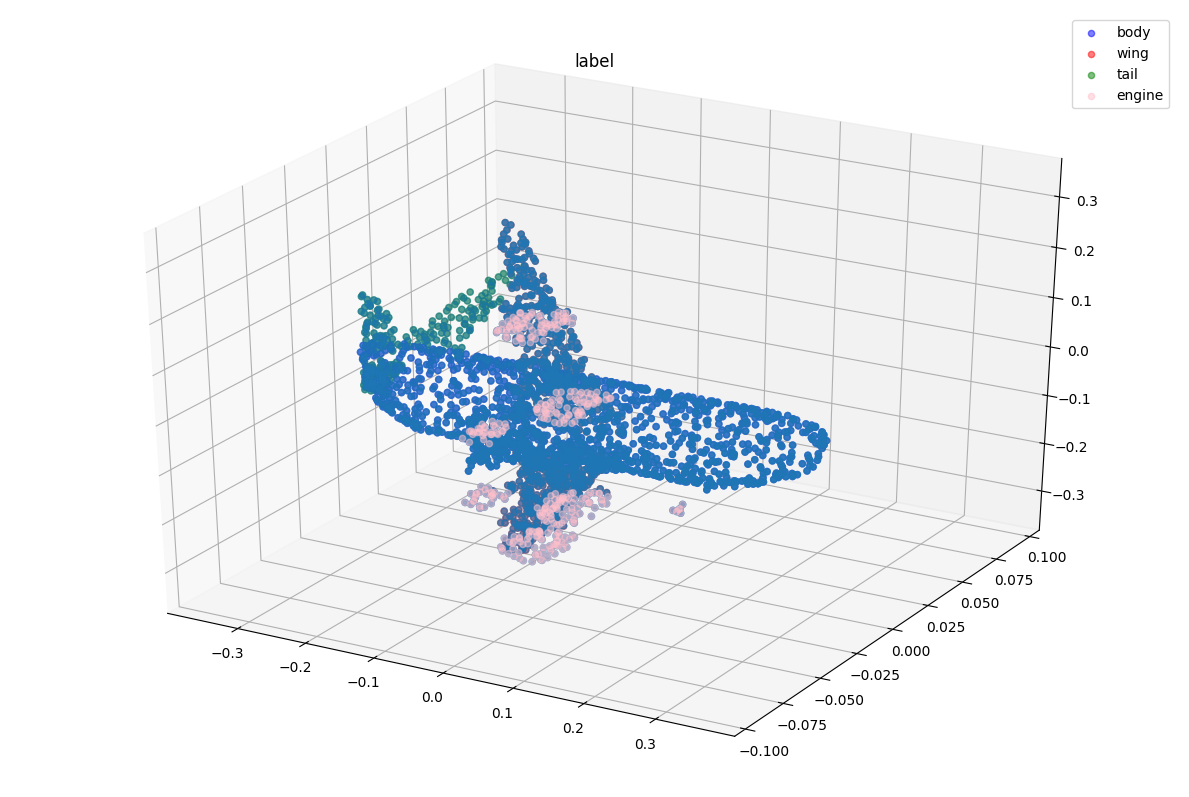

point cloud shape:(2593, 3)
label shape:(2593,)


In [22]:
# 可视化使用的颜色和对应label的名字
COLORS = [" ", "b", "r", "g", "pink"]
label_map = ["", "body", "wing", "tail", "engine"]


def visualize_data(point_cloud, label, title):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": label,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    ax.scatter(df["x"], df["y"], df["z"])
    for i in range(label.min(), label.max() + 1):
        c_df = df[df["label"] == i]
        ax.scatter(
            c_df["x"],
            c_df["y"],
            c_df["z"],
            label=label_map[i],
            alpha=0.5,
            c=COLORS[i],
        )
    ax.legend()
    plt.title(title)
    plt.show()


show_point_cloud_path = "dataset/shapenet/train_data/Airplane/000043.pts"
show_label_path = "dataset/shapenet/train_label/Airplane/000043.seg"
# 读取点云文件
point_cloud = np.loadtxt(show_point_cloud_path)
label = np.loadtxt(show_label_path).astype("int")
visualize_data(point_cloud, label, "label")
print("point cloud shape:{}".format(point_cloud.shape))
print("label shape:{}".format(label.shape))

### 3.2数据获取与预处理

根据上面的可视化分析，我们可以知道，每个数据中点云N的数量是不同的，这不利于我们进行后续的处理，所以这里对数据集中的点云进行了随机采样，使每个点云的数量一致，此外，我们也将点云的坐标进行了正则化操作，最后将处理好的点云存储在内存中，方便后续dataset的构建。

PS:此数据集中不仅包含Airplane类别，还包括Bag，Cap，Car和Chair类别，有兴趣可以自己修改数据集路径进行使用。



In [23]:
data_path = "dataset/shapenet/train_data/Airplane"
label_path = "dataset/shapenet/train_label/Airplane"
# 采样点
NUM_SAMPLE_POINTS = 1024
# 存储点云与label
point_clouds = []
point_clouds_labels = []

file_list = os.listdir(data_path)
for file_name in tqdm.tqdm(file_list):
    # 获取label和data的地址
    label_name = file_name.replace(".pts", ".seg")
    point_cloud_file_path = os.path.join(data_path, file_name)
    label_file_path = os.path.join(label_path, label_name)
    # 读取label和data
    point_cloud = np.loadtxt(point_cloud_file_path)
    label = np.loadtxt(label_file_path).astype("int")
    # 如果本身的点少于需要采样的点，则直接去除
    if len(point_cloud) < NUM_SAMPLE_POINTS:
        continue
    # 采样
    num_points = len(point_cloud)
    # 确定随机采样的index
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # 点云采样
    sampled_point_cloud = np.array([point_cloud[i] for i in sampled_indices])
    # label采样
    sampled_label_cloud = np.array([label[i] for i in sampled_indices])
    # 正则化
    norm_point_cloud = sampled_point_cloud - np.mean(
        sampled_point_cloud, axis=0
    )
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    # 存储
    point_clouds.append(norm_point_cloud)
    point_clouds_labels.append(sampled_label_cloud)

100%|██████████| 1958/1958 [00:55<00:00, 35.41it/s]


可视化看一下采样后的点云和之前的区别。

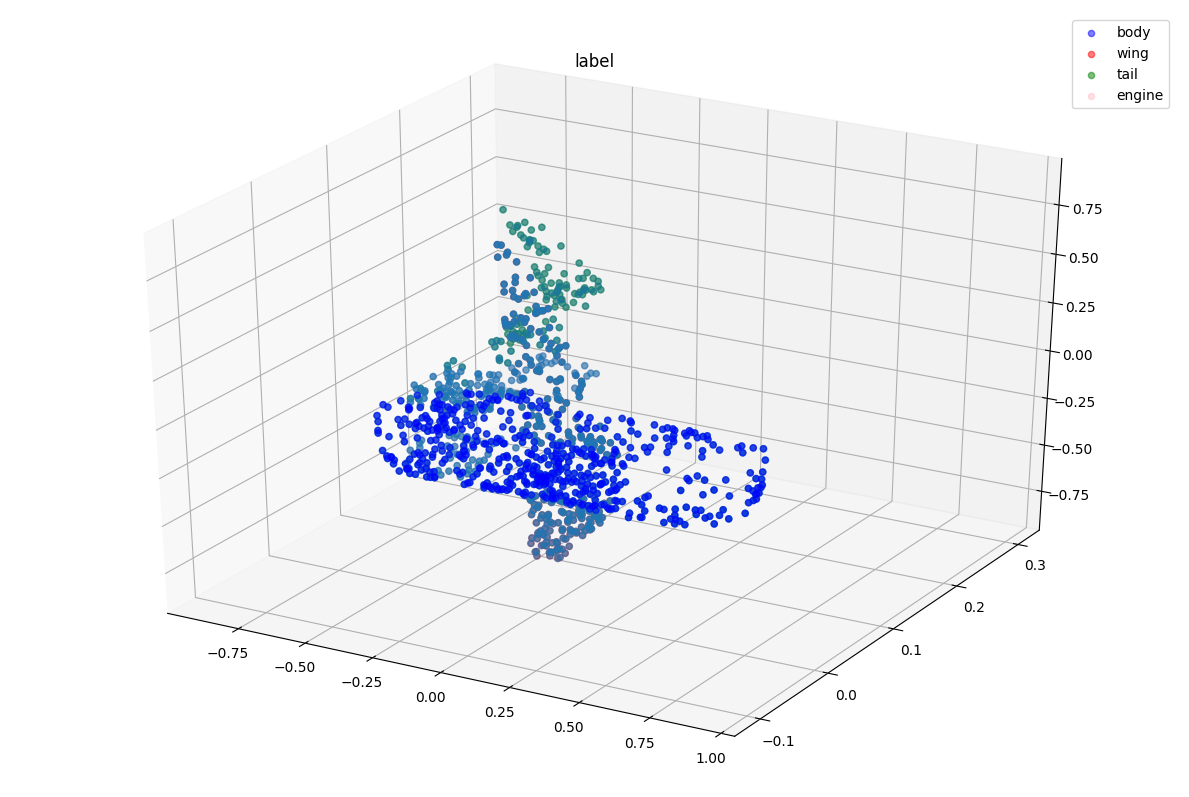

In [24]:
visualize_data(point_clouds[0], point_clouds_labels[0], "label")

### 3.3数据集定义

在Paddle中，数据集的定义只需要完成以下四步即可：

* paddle.io.Dataset的继承

* 构造函数的实现，主要完成一些初始化

* __gtitem__方法的实现，即定义index时，可以返回对应的单条数据，包括训练数据和对应的标签

* __len__方法的实现，即获取数据的大小

此外，这里还对数据集进行了训练集和验证集的划分，划分比例为验证集占总体的20%，并将定义好的数据集，通过paddle.io.DataLoader进行迭代器的封装，方便训练过程数据的读取操作。

In [25]:
class MyDataset(Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """

    def __init__(self, data, label):
        """
        步骤二：实现构造函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        self.data = data
        self.label = label

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        data = self.data[index]
        # 减1是因为原始label中是从1开始算类别数的
        label = self.label[index] - 1
        data = np.reshape(data, (1, 1024, 3))

        return data, label

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return len(self.data)


# 数据集划分
VAL_SPLIT = 0.2
split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = point_clouds_labels[:split_index]
total_training_examples = len(train_point_clouds)
val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_clouds_labels[split_index:]
print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

# 测试定义的数据集
train_dataset = MyDataset(train_point_clouds, train_label_cloud)
val_dataset = MyDataset(val_point_clouds, val_label_cloud)

print("=============custom dataset test=============")
for data, label in train_dataset:
    print("data shape:{} \nlabel shape:{}".format(data.shape, label.shape))
    break

# Batch_size 大小
BATCH_SIZE = 64
# # 数据加载
train_loader = paddle.io.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = paddle.io.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False
)

Num train point clouds: 1566
Num train point cloud labels: 1566
Num val point clouds: 392
Num val point cloud labels: 392
=============custom dataset test=============
data shape:(1, 1024, 3) 
label shape:(1024,)


## 4、模型组网

在模型组网前，先对本次项目使用的PointNet网络做一个简单的的介绍。

### 4.1 PointNet介绍


![](https://ai-studio-static-online.cdn.bcebos.com/78852aff0dcc45b78ca61500a2ccf17eb86c5a95eb684f0e86f217abed9955d2)

PointNet网络的设计思路，主要解决以下三个问题：点云的无序性，点云之间的交互性和点云的变换不变性。

* **点云的无序性：**对称函数（symmetry function）的应用，如加法、乘法和取最大值函数等，在PointNet则是采用了maxpooling（最大值汇聚）的方法

* **点云的交互性：** 在分割网络的分支里，可以看到其将某一层的信息和经过maxpooling得到的全局信息进行concate来达到全局和局部信息的交互

* **点云的变换不变性：** 在点云中，不论怎么旋转应该都不会改变其属性。在此前有人设计变换矩阵，以数据增强的方法来解决这个问题。而作者这里直接将这个变换矩阵的学习也融入到网络中，设计了input transform结构。

另外，由于网络最终要使用maxpooling来进行汇聚特征，而原始的点云是（N,3）的特征，也即只有3维特征，所以作者利用了MLP来进行升维后再进行汇聚的操作。

在分割网络里，作者通过concate全局特征和局部特征，构造一个语义特征更强的特征形式，后面就是常规的通过MLP网络进行降维后生成预测点云。

更加详细的细节，可以查看原论文和下面的代码：[论文地址](https://arxiv.org/abs/1612.00593)

其中代码中的网络定义，对应网络细节如下：

* input_transform_net+input_fc：对应T-Net，后续reshape到3x3做为变换矩阵和输入进行变换

* mlp：对应升维的MLP层

* seg_net：对应Segmentation Network中一系列的MLP层

**其中代码中的MLP层，均使用了1x1的卷积层来进行代替。**



### 4.2 Paddle模型组网

Paddle中的组网和torch中无大致区别，继承nn.Layer后，重写前向传播forward即可




In [26]:
class PointNet(paddle.nn.Layer):
    def __init__(self, name_scope="PointNet_", num_classes=4, num_point=1024):
        super(PointNet, self).__init__()
        self.num_point = num_point
        self.input_transform_net = Sequential(
            Conv2D(1, 64, (1, 3)),
            BatchNorm(64),
            ReLU(),
            Conv2D(64, 128, (1, 1)),
            BatchNorm(128),
            ReLU(),
            Conv2D(128, 1024, (1, 1)),
            BatchNorm(1024),
            ReLU(),
            MaxPool2D((num_point, 1)),
        )
        self.input_fc = Sequential(
            Linear(1024, 512),
            ReLU(),
            Linear(512, 256),
            ReLU(),
            Linear(
                256,
                9,
                weight_attr=paddle.framework.ParamAttr(
                    initializer=paddle.nn.initializer.Assign(
                        paddle.zeros((256, 9))
                    )
                ),
                bias_attr=paddle.framework.ParamAttr(
                    initializer=paddle.nn.initializer.Assign(
                        paddle.reshape(paddle.eye(3), [-1])
                    )
                ),
            ),
        )
        self.mlp_1 = Sequential(
            Conv2D(1, 64, (1, 3)),
            BatchNorm(64),
            ReLU(),
            Conv2D(64, 64, (1, 1)),
            BatchNorm(64),
            ReLU(),
        )
        self.feature_transform_net = Sequential(
            Conv2D(64, 64, (1, 1)),
            BatchNorm(64),
            ReLU(),
            Conv2D(64, 128, (1, 1)),
            BatchNorm(128),
            ReLU(),
            Conv2D(128, 1024, (1, 1)),
            BatchNorm(1024),
            ReLU(),
            MaxPool2D((num_point, 1)),
        )
        self.feature_fc = Sequential(
            Linear(1024, 512),
            ReLU(),
            Linear(512, 256),
            ReLU(),
            Linear(256, 64 * 64),
        )
        self.mlp_2 = Sequential(
            Conv2D(64, 64, (1, 1)),
            BatchNorm(64),
            ReLU(),
            Conv2D(64, 128, (1, 1)),
            BatchNorm(128),
            ReLU(),
            Conv2D(128, 1024, (1, 1)),
            BatchNorm(1024),
            ReLU(),
        )
        self.seg_net = Sequential(
            Conv2D(1088, 512, (1, 1)),
            BatchNorm(512),
            ReLU(),
            Conv2D(512, 256, (1, 1)),
            BatchNorm(256),
            ReLU(),
            Conv2D(256, 128, (1, 1)),
            BatchNorm(128),
            ReLU(),
            Conv2D(128, 128, (1, 1)),
            BatchNorm(128),
            ReLU(),
            Conv2D(128, num_classes, (1, 1)),
            Softmax(axis=1),
        )

    def forward(self, inputs):
        batchsize = inputs.shape[0]

        t_net = self.input_transform_net(inputs)
        t_net = paddle.squeeze(t_net)
        t_net = self.input_fc(t_net)
        t_net = paddle.reshape(t_net, [batchsize, 3, 3])

        x = paddle.reshape(inputs, shape=(batchsize, 1024, 3))
        x = paddle.matmul(x, t_net)
        x = paddle.unsqueeze(x, axis=1)
        x = self.mlp_1(x)

        t_net = self.feature_transform_net(x)
        t_net = paddle.squeeze(t_net)
        t_net = self.feature_fc(t_net)
        t_net = paddle.reshape(t_net, [batchsize, 64, 64])

        x = paddle.reshape(x, shape=(batchsize, 64, 1024))
        x = paddle.transpose(x, (0, 2, 1))
        x = paddle.matmul(x, t_net)
        x = paddle.transpose(x, (0, 2, 1))
        x = paddle.unsqueeze(x, axis=-1)
        point_feat = x
        x = self.mlp_2(x)
        x = paddle.max(x, axis=2)

        global_feat_expand = paddle.tile(
            paddle.unsqueeze(x, axis=1), [1, self.num_point, 1, 1]
        )
        x = paddle.concat([point_feat, global_feat_expand], axis=1)
        x = self.seg_net(x)
        x = paddle.squeeze(x, axis=-1)
        x = paddle.transpose(x, (0, 2, 1))

        return x

### 4.3 模型可视化

In [28]:
pointnet = PointNet()
paddle.summary(pointnet, (64, 1, 1024, 3))

----------------------------------------------------------------------------
 Layer (type)        Input Shape          Output Shape         Param #    
   Conv2D-17     [[64, 1, 1024, 3]]    [64, 64, 1024, 1]         256      
 BatchNorm-16    [[64, 64, 1024, 1]]   [64, 64, 1024, 1]         256      
    ReLU-20      [[64, 64, 1024, 1]]   [64, 64, 1024, 1]          0       
   Conv2D-18     [[64, 64, 1024, 1]]   [64, 128, 1024, 1]       8,320     
 BatchNorm-17   [[64, 128, 1024, 1]]   [64, 128, 1024, 1]        512      
    ReLU-21     [[64, 128, 1024, 1]]   [64, 128, 1024, 1]         0       
   Conv2D-19    [[64, 128, 1024, 1]]  [64, 1024, 1024, 1]      132,096    
 BatchNorm-18   [[64, 1024, 1024, 1]] [64, 1024, 1024, 1]       4,096     
    ReLU-22     [[64, 1024, 1024, 1]] [64, 1024, 1024, 1]         0       
  MaxPool2D-3   [[64, 1024, 1024, 1]]   [64, 1024, 1, 1]          0       
   Linear-7         [[64, 1024]]           [64, 512]           524,800    
    ReLU-23          [[

{'total_params': 3559501, 'trainable_params': 3540301}

## 5、模型训练

模型训练中使用的参数如下：

* 优化器：Adam，其中weight_decay=0.001

* 损失函数：CrossEntropyLoss

* 训练轮数：epoch_num=50

* 保存轮数：save_interval=2

* 模型保存地址：output_dir='./output'

In [ ]:
# 创建模型
model = PointNet()
model.train()
# 优化器定义
optim = paddle.optimizer.Adam(parameters=model.parameters(), weight_decay=0.001)
# 损失函数定义
loss_fn = paddle.nn.CrossEntropyLoss()
# 评价指标定义
m = paddle.metric.Accuracy()
# 训练轮数
epoch_num = 50
# 每多少个epoch保存
save_interval = 2
# 每多少个epoch验证
val_interval = 2
best_acc = 0
# 模型保存地址
output_dir = "./output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# 训练过程
plot_acc = []
plot_loss = []
for epoch in range(epoch_num):
    total_loss = 0
    for batch_id, data in enumerate(train_loader()):
        inputs = paddle.to_tensor(data[0], dtype="float32")
        labels = paddle.to_tensor(data[1], dtype="int64")
        predicts = model(inputs)

        # 计算损失和反向传播
        loss = loss_fn(predicts, labels)
        total_loss = total_loss + loss.numpy()[0]
        loss.backward()
        # 计算acc
        predicts = paddle.reshape(
            predicts, (predicts.shape[0] * predicts.shape[1], -1)
        )
        labels = paddle.reshape(labels, (labels.shape[0] * labels.shape[1], 1))
        correct = m.compute(predicts, labels)
        m.update(correct)
        # 优化器更新
        optim.step()
        optim.clear_grad()
    avg_loss = total_loss / batch_id
    plot_loss.append(avg_loss)
    print(
        "epoch: {}/{}, loss is: {}, acc is:{}".format(
            epoch, epoch_num, avg_loss, m.accumulate()
        )
    )
    m.reset()
    # 保存
    if epoch % save_interval == 0:
        model_name = str(epoch)
        paddle.save(
            model.state_dict(),
            "./output/PointNet_{}.pdparams".format(model_name),
        )
        paddle.save(
            optim.state_dict(), "./output/PointNet_{}.pdopt".format(model_name)
        )
    # 训练中途验证
    if epoch % val_interval == 0:
        model.eval()
        for batch_id, data in enumerate(val_loader()):
            inputs = paddle.to_tensor(data[0], dtype="float32")
            labels = paddle.to_tensor(data[1], dtype="int64")
            predicts = model(inputs)
            predicts = paddle.reshape(
                predicts, (predicts.shape[0] * predicts.shape[1], -1)
            )
            labels = paddle.reshape(
                labels, (labels.shape[0] * labels.shape[1], 1)
            )
            correct = m.compute(predicts, labels)
            m.update(correct)
        val_acc = m.accumulate()
        plot_acc.append(val_acc)
        if val_acc > best_acc:
            best_acc = val_acc
            print(
                "===================================val==========================================="
            )
            print("val best epoch in:{}, best acc:{}".format(epoch, best_acc))
            print(
                "===================================train==========================================="
            )
            paddle.save(model.state_dict(), "./output/best_model.pdparams")
            paddle.save(optim.state_dict(), "./output/best_model.pdopt")
        m.reset()
        model.train()

可视化模型训练过程

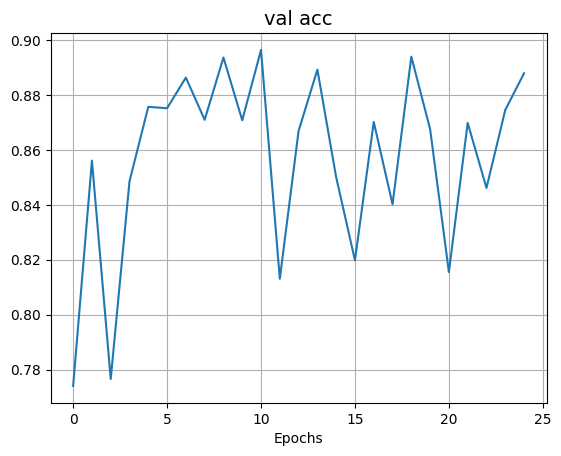

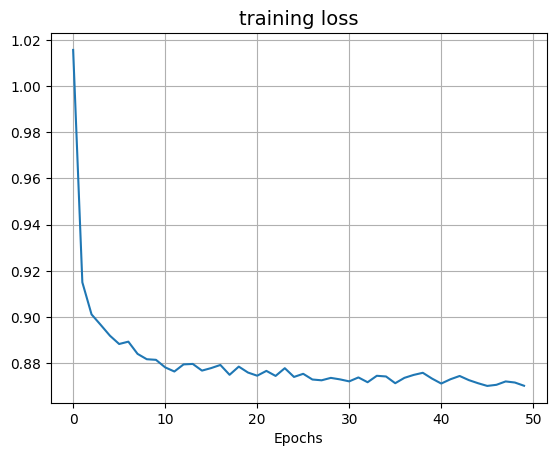

In [30]:
def plot_result(item, title):
    plt.figure()
    plt.xlabel("Epochs")
    plt.plot(item)
    plt.title(title, fontsize=14)
    plt.grid()
    plt.show()


plot_result(plot_acc, "val acc")
plot_result(plot_loss, "training loss")

## 6、模型预测

In [32]:
ckpt_path = "output/best_model.pdparams"
para_state_dict = paddle.load(ckpt_path)
# 加载网络和参数
model = PointNet()
model.set_state_dict(para_state_dict)
model.eval()
# 加载数据集
point_cloud = point_clouds[0]
show_point_cloud = point_cloud
point_cloud = paddle.to_tensor(
    np.reshape(point_cloud, (1, 1, 1024, 3)), dtype="float32"
)
label = point_clouds_labels[0]
# 前向推理
preds = model(point_cloud)
show_pred = paddle.argmax(preds, axis=-1).numpy() + 1

可视化结果

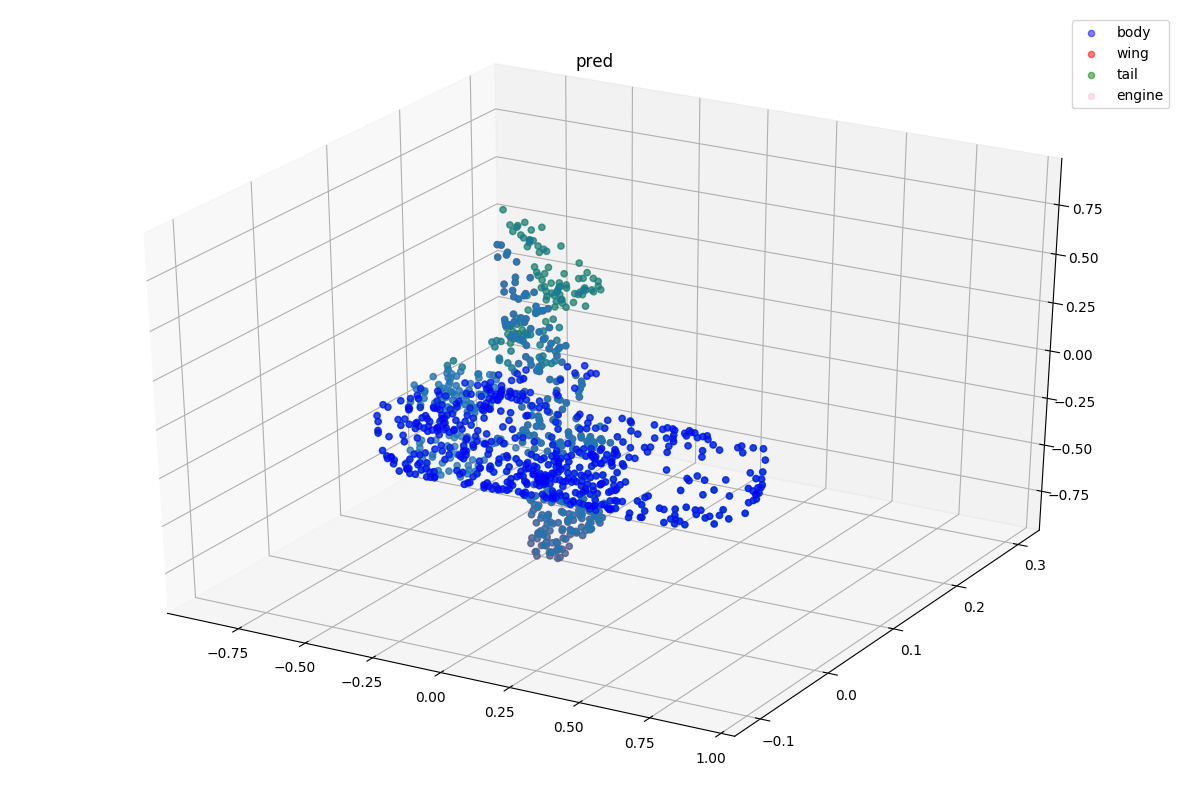

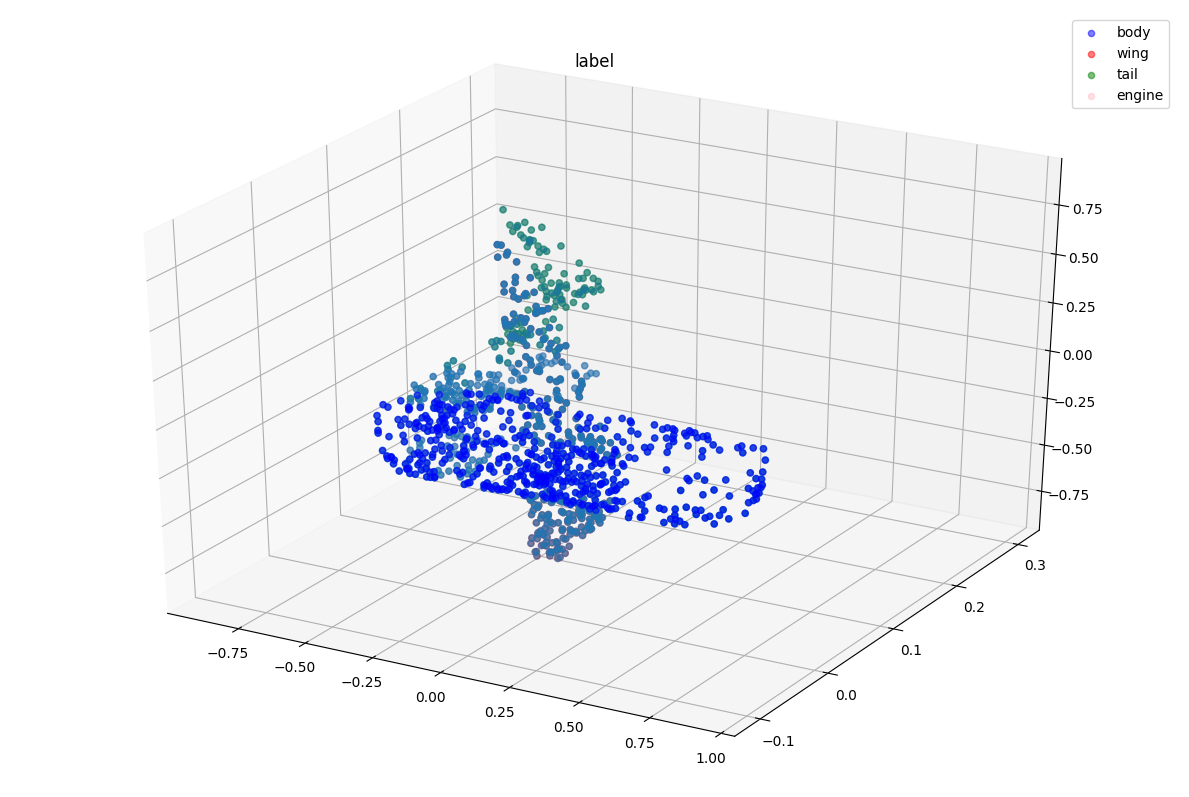

In [33]:
visualize_data(show_point_cloud, show_pred[0], "pred")
visualize_data(show_point_cloud, label, "label")

## 7、总结

本项目从点云数据的分析出发，利用Paddle框架，实现了数据集构建，模型组网，训练和预测全流程开发，实现了对于点云数据的part segmentation任务
